# Feature Selection in Data Science: A Hybrid Approach

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import warnings
warnings.filterwarnings('ignore')

## Feature Selector Implementation

In [2]:
class FeatureSelector:
    """A hybrid feature selection method combining tree-based importance and clustering."""
    
    def __init__(self, task_type='classification', n_clusters=5, importance_threshold=0.01):
        self.task_type = task_type
        self.n_clusters = n_clusters
        self.importance_threshold = importance_threshold
        
        # Initialize the appropriate model based on task type
        if task_type == 'classification':
            self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        else:
            self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        
        self.selected_features_ = None
        self.feature_importance_ = None
    
    def fit(self, X, y):
        # Calculate feature importance
        self.model.fit(X, y)
        importance = self.model.feature_importances_
        self.feature_importance_ = pd.Series(importance, index=X.columns)
        
        # Get important features
        important_features = self.feature_importance_[
            self.feature_importance_ > self.importance_threshold]
        
        if len(important_features) < self.n_clusters:
            self.selected_features_ = list(important_features.index)
            return self
        
        # Cluster features based on correlation
        corr_matrix = X[important_features.index].corr().abs()
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        scaled_corr = StandardScaler().fit_transform(corr_matrix)
        clusters = kmeans.fit_predict(scaled_corr)
        
        # Select best feature from each cluster
        selected_features = []
        for cluster in range(self.n_clusters):
            cluster_features = important_features[clusters == cluster]
            if len(cluster_features) > 0:
                best_feature = cluster_features.idxmax()
                selected_features.append(best_feature)
        
        self.selected_features_ = selected_features
        return self
    
    def transform(self, X):
        if self.selected_features_ is None:
            raise ValueError("Call fit first.")
        return X[self.selected_features_]
    
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

## Evaluation Functions

In [3]:
def evaluate_method(X, y, method, task_type='classification'):
    """Evaluate a feature selection method."""
    # Time the selection process
    start_time = time.time()
    
    # Handle PCA separately since it doesn't need y for fit
    if isinstance(method, PCA):
        X_selected = method.fit_transform(X)
    else:
        # For other methods, use fit_transform with both X and y
        X_selected = method.fit_transform(X, y)
    
    selection_time = time.time() - start_time
    
    # Create appropriate model and scorer based on task type
    if task_type == 'classification':
        model = RandomForestClassifier(random_state=42)
        scorer = make_scorer(accuracy_score)
    else:
        model = RandomForestRegressor(random_state=42)
        scorer = make_scorer(r2_score)
    
    # Calculate scores
    scores = cross_val_score(model, X_selected, y, scoring=scorer, cv=5)
    
    return {
        'mean_score': scores.mean(),
        'std_score': scores.std(),
        'selection_time': selection_time,
        'n_features': X_selected.shape[1]
    }

def compare_methods(X, y, task_type='classification', n_features=5):
    """Compare different feature selection methods."""
    # Create base estimator based on task type
    if task_type == 'classification':
        base_estimator = RandomForestClassifier(random_state=42)
    else:
        base_estimator = RandomForestRegressor(random_state=42)
    
    # Initialize methods
    methods = {
        'Our Method': FeatureSelector(task_type=task_type, n_clusters=n_features),
        'RFE': RFE(estimator=base_estimator, n_features_to_select=n_features),
        'PCA': PCA(n_components=n_features)
    }
    
    # Evaluate each method
    results = {}
    for name, method in methods.items():
        results[name] = evaluate_method(X, y, method, task_type)
    
    return results

def plot_comparison(results, title):
    """Create comparison plots."""
    metrics = ['mean_score', 'n_features', 'selection_time']
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, metric in enumerate(metrics):
        data = [results[method][metric] for method in results.keys()]
        axes[i].bar(results.keys(), data)
        axes[i].set_title(f'{metric.replace("_", " ").title()}')
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for j, v in enumerate(data):
            axes[i].text(j, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.suptitle(title, y=1.05)
    plt.tight_layout()
    plt.show()

## Run Experiments


Wine Dataset Results:

Detailed Results:
                Our Method     RFE     PCA
mean_score          0.9722  0.9498  0.9165
std_score           0.0248  0.0323  0.0607
selection_time      0.1741  1.2620  0.0133
n_features          5.0000  5.0000  5.0000


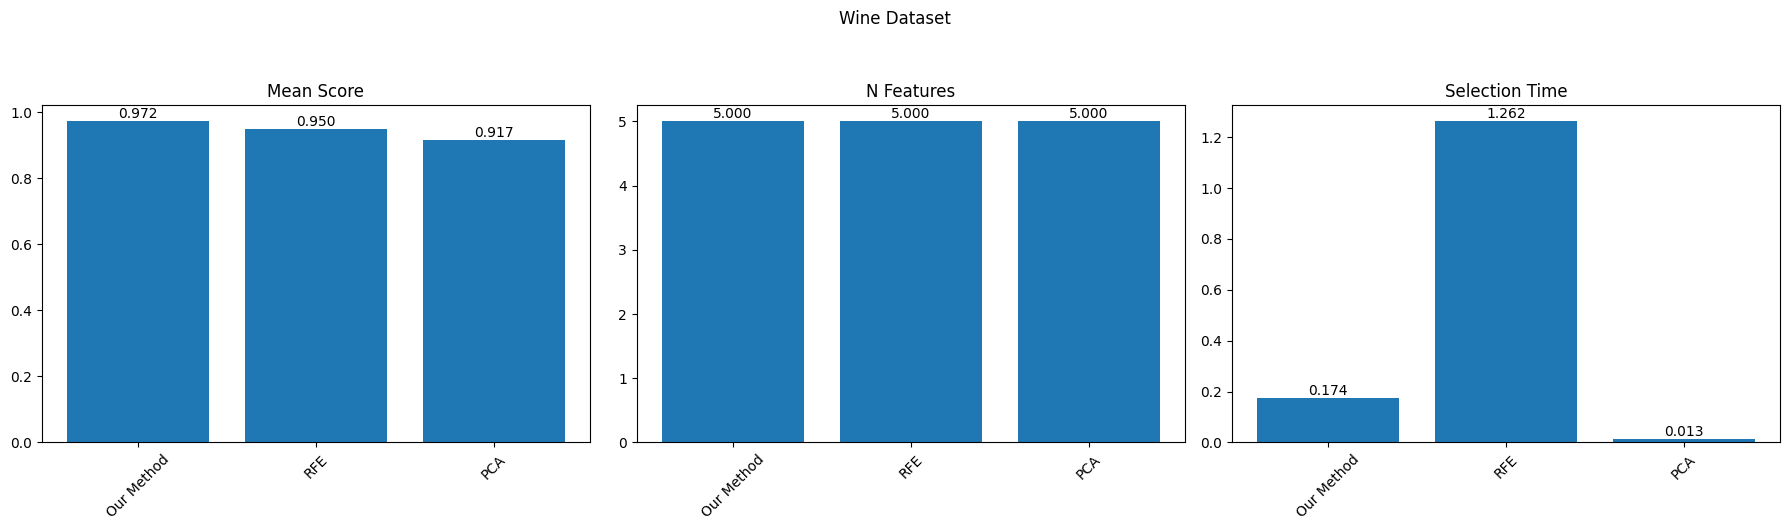


Housing Dataset Results:

Detailed Results:
                Our Method      RFE     PCA
mean_score          0.5254   0.6320  0.3167
std_score           0.1326   0.0762  0.1731
selection_time     15.9865  52.4988  0.0061
n_features          5.0000   5.0000  5.0000


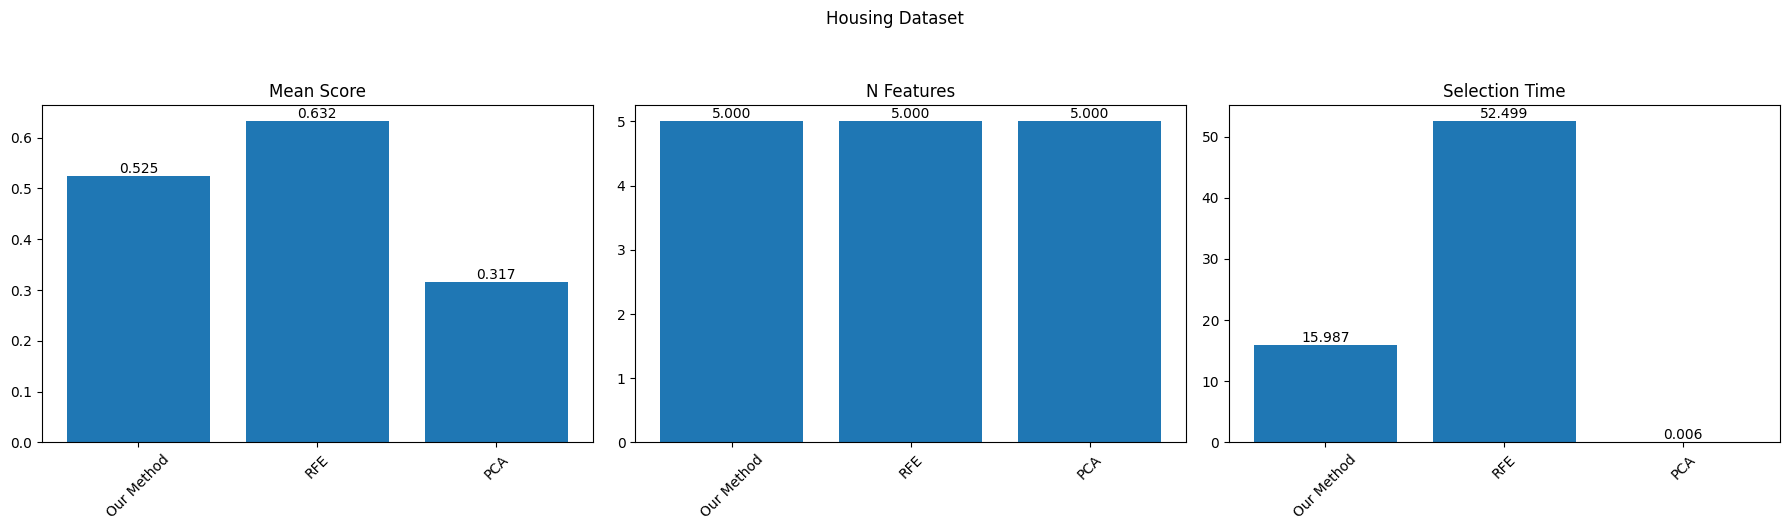


Cancer Dataset Results:

Detailed Results:
                Our Method     RFE     PCA
mean_score          0.9561  0.9455  0.9508
std_score           0.0166  0.0217  0.0181
selection_time      0.3123  5.9367  0.0019
n_features          5.0000  5.0000  5.0000


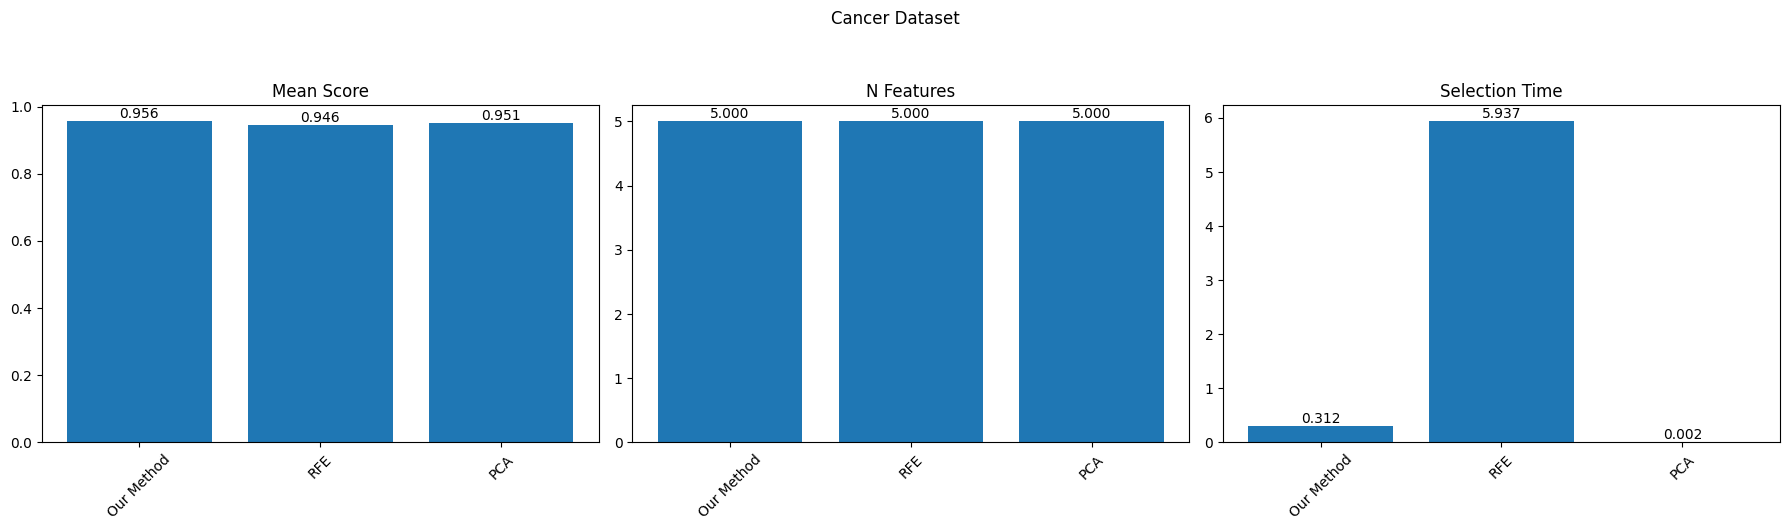


Diabetes Dataset Results:

Detailed Results:
                Our Method     RFE     PCA
mean_score          0.3734  0.3970  0.4595
std_score           0.0600  0.0507  0.1009
selection_time      0.2933  1.6349  0.0014
n_features          5.0000  5.0000  5.0000


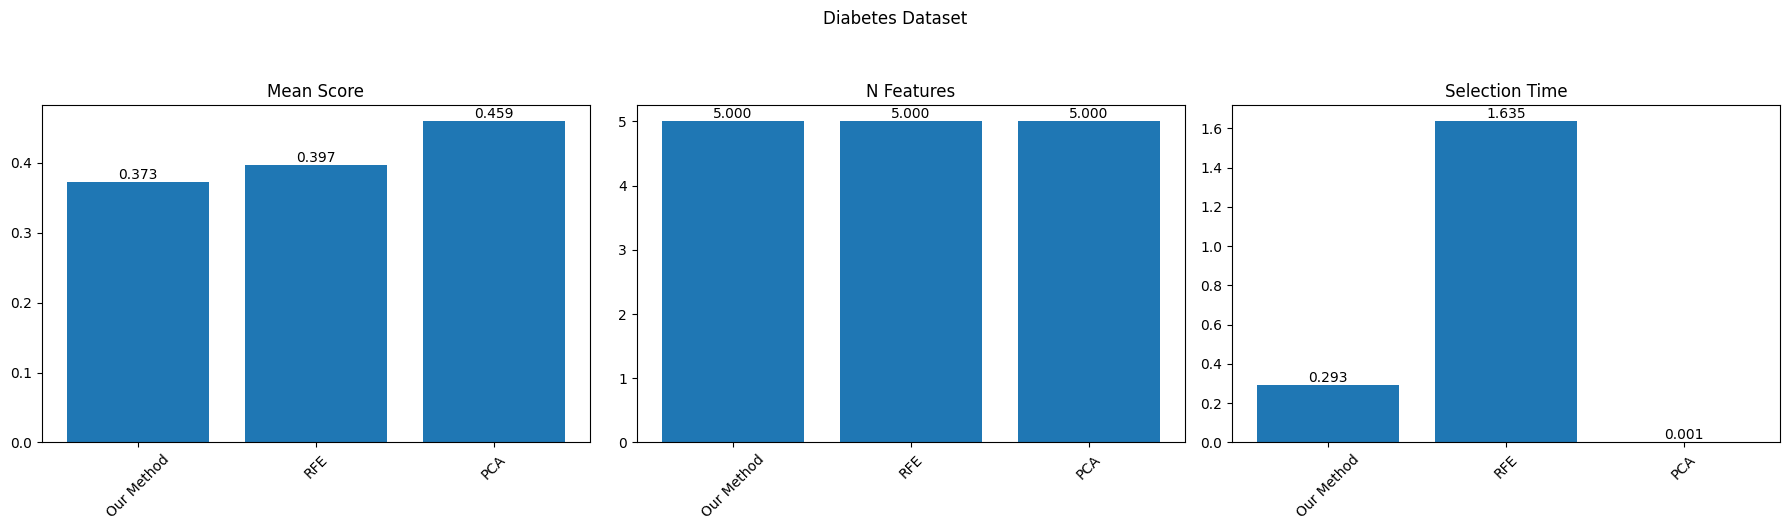

In [4]:
# Load datasets
from sklearn.datasets import load_wine, fetch_california_housing
from sklearn.datasets import load_breast_cancer, load_diabetes

# Prepare datasets
datasets = {
    'Wine': (load_wine(), 'classification'),
    'Housing': (fetch_california_housing(), 'regression'),
    'Cancer': (load_breast_cancer(), 'classification'),
    'Diabetes': (load_diabetes(), 'regression')
}

# Run experiments
for name, (data, task) in datasets.items():
    print(f"\n{name} Dataset Results:")
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = data.target
    results = compare_methods(X, y, task)
    print("\nDetailed Results:")
    print(pd.DataFrame(results).round(4))
    
    # Plot comparisons
    plot_comparison(results, f'{name} Dataset')

## Analyze Feature Groups


=== Wine Dataset Analysis ===


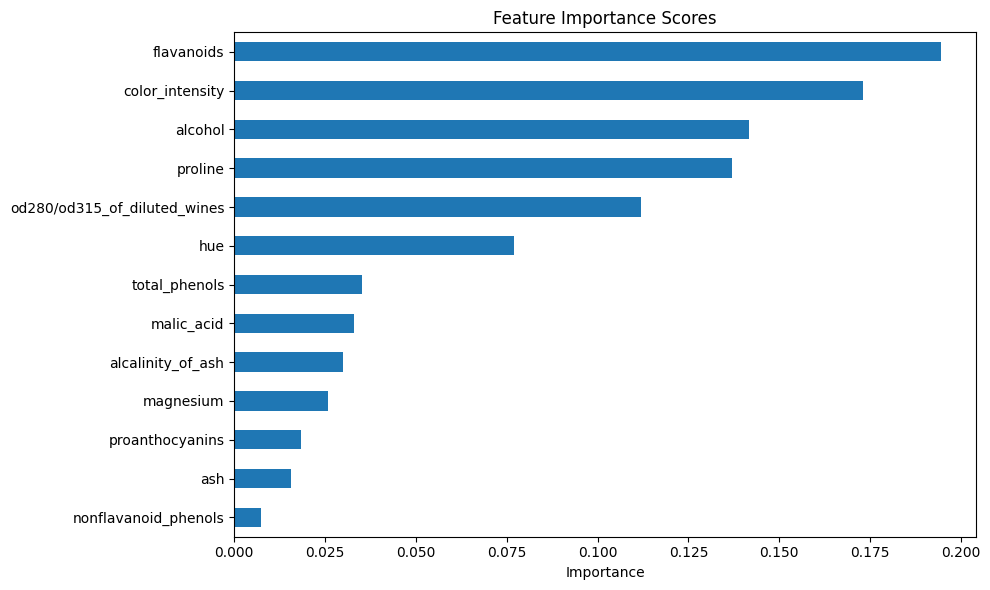


Selected Features:
magnesium: 0.0259
hue: 0.0769
alcohol: 0.1416
flavanoids: 0.1945
color_intensity: 0.1730

=== Housing Dataset Analysis ===


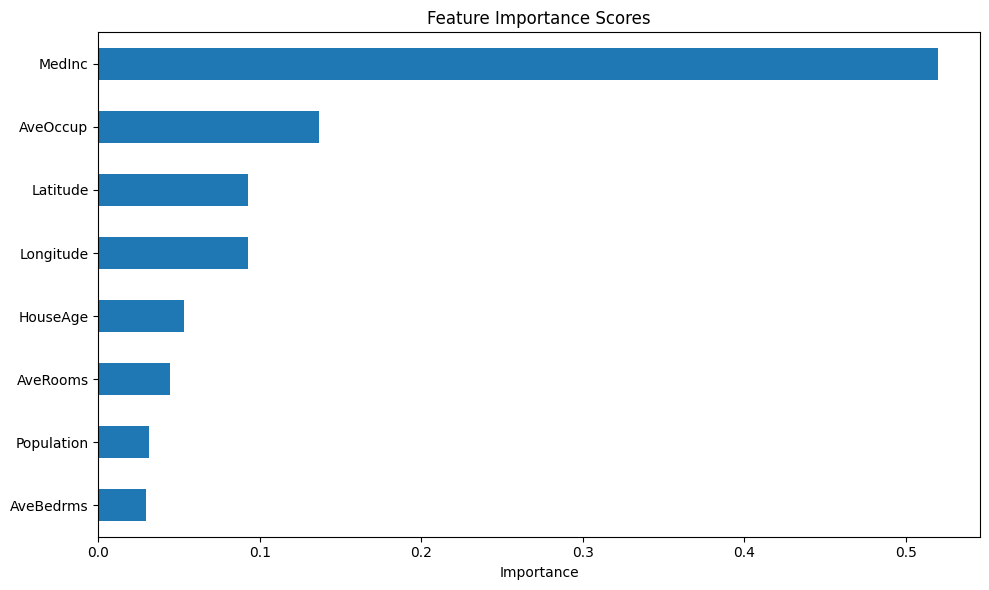


Selected Features:
AveRooms: 0.0445
Latitude: 0.0929
MedInc: 0.5200
HouseAge: 0.0530
AveOccup: 0.1364

=== Cancer Dataset Analysis ===


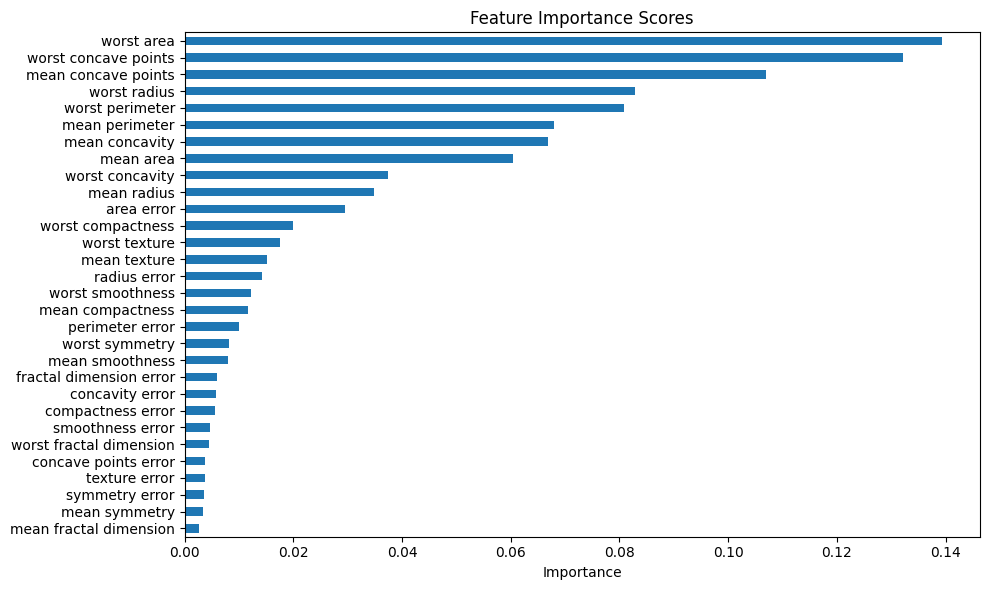


Selected Features:
worst concave points: 0.1322
worst texture: 0.0175
worst area: 0.1394
worst concavity: 0.0373
worst smoothness: 0.0122

=== Diabetes Dataset Analysis ===


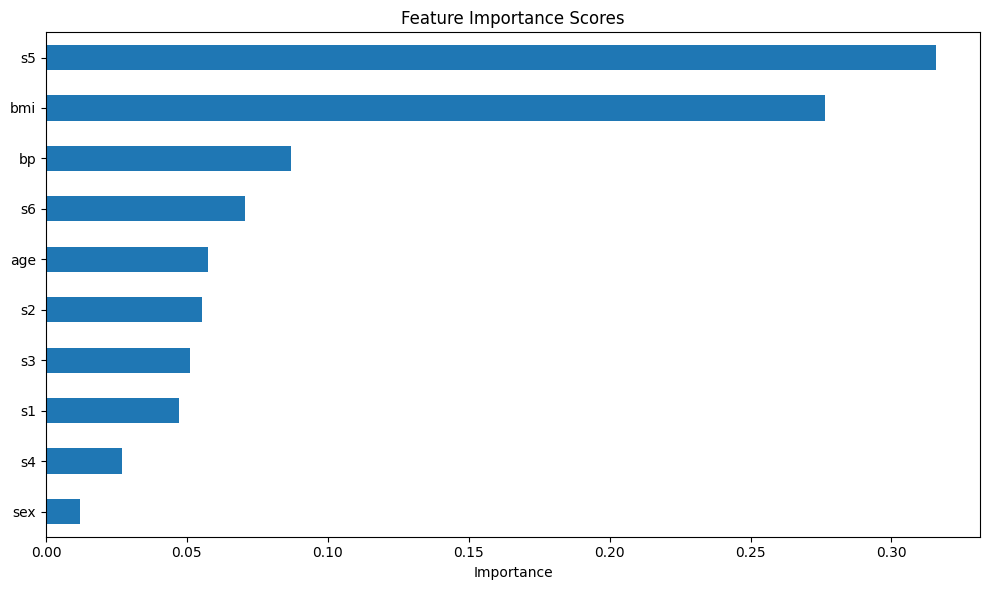


Selected Features:
bmi: 0.2762
s5: 0.3156
sex: 0.0119
s2: 0.0554
age: 0.0575


In [5]:
def analyze_selected_features(X, y, task_type):
    """Analyze which features were selected and why."""
    selector = FeatureSelector(task_type=task_type)
    selector.fit(X, y)
    
    # Create feature importance visualization
    plt.figure(figsize=(10, 6))
    selector.feature_importance_.sort_values().plot(kind='barh')
    plt.title('Feature Importance Scores')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    # Print selected features and their importance
    print("\nSelected Features:")
    for feature in selector.selected_features_:
        print(f"{feature}: {selector.feature_importance_[feature]:.4f}")

# Analyze each dataset
for name, (data, task) in datasets.items():
    print(f"\n=== {name} Dataset Analysis ===")
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = data.target
    analyze_selected_features(X, y, task)